In [1]:
import numpy as np
import scipy as sp

import pystan
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [2]:
np.random.seed(32532)

In [3]:
def draw_gmm_data(n_obs, n_clusters, dim, sigma): 
    # draw centroids
    mu = np.random.multivariate_normal(np.zeros(dim), np.eye(dim), n_clusters)
    
    # draw cluster belongings with
    # uniform weights
    weights = np.ones(n_clusters) * 1 / n_clusters
    z_ind = np.random.choice(n_clusters, p = weights, size = n_obs)
    
    # draw data
    y = np.zeros((n_obs, dim))
    for k in range(n_clusters): 
        num_in_cluster = np.sum(z_ind == k)
        samples = np.random.multivariate_normal(mu[k, :], np.eye(dim) * sigma, size = num_in_cluster)
        
        y[z_ind == k, :] = samples
    
    return y, mu, z_ind

In [4]:
n_obs = 1000
n_clusters = 3
dim = 2
sigma = 0.1

In [27]:
mu

array([[-0.62330223, -0.82921814],
       [-3.01202652,  0.56674673],
       [-1.57964501,  0.2514442 ]])

In [5]:
y, mu, z_ind = draw_gmm_data(n_obs, n_clusters, dim, sigma)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    # Centroids should be dim x n_clusters 
    # Cov should be n_clusters x dim x dim 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

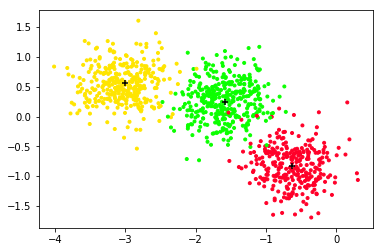

In [7]:
import matplotlib.cm as cm
cmap = cm.get_cmap(name='gist_rainbow')

colors = [cmap(k * 50) for k in range(12)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(y[:, 0], y[:, 1], z_ind, colors, fig, centroids = mu.T)

In [8]:
gmm_mixture = """
functions {
vector get_weights_from_sticks (vector sticks){
    int n_clust = num_elements(sticks) + 1; // number of clusters
    vector[n_clust] weights; // the weights we shall return
    
    vector[n_clust - 1] sticks_1m = 1 - sticks; // 1 minus the sticks
        
    // get sticks remaining
    vector[n_clust] sticks_remaining; 
    sticks_remaining[1] = 1; 
    for(k in 2:n_clust){
        sticks_remaining[k] = sticks_remaining[k-1] * sticks_1m[k-1]; 
    }
    
    // get weights
    weights[1:(n_clust -1)] = sticks_remaining[1:(n_clust -1)] .* sticks; 
    weights[n_clust] = sticks_remaining[n_clust]; 

    
    return weights; 
    }

}
data {
    // size parameters
    int n_obs; // number of observations
    int dim; // number of dimensions in data
    int n_clusters; // number of components
    
    // the data    
    matrix[n_obs, dim] y; // observed data
    
    // prior parameters
    real <lower=0> alpha; // DP parameter 
    real mu_prior_var; // prior variance on the centroids
    real <lower=0> wishart_df;  // wishart degrees of freedom parameter
    cov_matrix[dim] inv_wishart_scale;  // inv wishart scale parameter
}

parameters {
    matrix[n_clusters, dim] mu; // the centroids
    vector <lower=0,upper=1>[n_clusters - 1] sticks; // BNP sticks
    cov_matrix[dim] sigma[n_clusters]; 
}
model {
    vector[n_clusters] contributions;
    vector[n_clusters] weights; 
    
    // priors
    for(k in 1:n_clusters) {
        // draw centroids
        mu[k] ~ multi_normal(rep_vector(0.0, dim), diag_matrix(rep_vector(mu_prior_var, dim)));
        // draw covariances 
        sigma[k] ~ inv_wishart(wishart_df, inv_wishart_scale); 
        
        if (k < n_clusters){
            sticks[k] ~ beta(1, alpha); 
      }
    }
    weights = get_weights_from_sticks(sticks); 
        
  
    // likelihood
    for(i in 1:n_obs) {
        for(k in 1:n_clusters) {
          contributions[k] = log(weights[k]) + multi_normal_lpdf(y[i] | mu[k], sigma[k]);
        }
    target += log_sum_exp(contributions);
    }
}

"""

In [9]:
load_model = True
save_model = False

In [10]:
if load_model: 
    file = 'gmm_mixture_model.pkl'
    gmm_mixture_model = pickle.load(open(file, 'rb'))
else: 
    gmm_mixture_model = pystan.StanModel(model_code = gmm_mixture)
    
if save_model: 
    model_name = 'gmm_mixture_model.pkl'
    with open(model_name, 'wb') as f:
        pickle.dump(gmm_mixture_model, f)

In [11]:
def get_default_data_model(y, n_clusters): 
    n_obs = np.shape(y)[0]
    dim = np.shape(y)[1]
    
    wishart_df = 8
    inv_wishart_scale = np.eye(dim) * 0.62
    
    data = dict(n_obs = n_obs, 
                dim = dim, 
                n_clusters = n_clusters, 
                y = y, 
                alpha = 4.0, # DP parameter
                mu_prior_var = 10.0, # Prior variance on centroids
                wishart_df = wishart_df, # inv. wishart prior df
                inv_wishart_scale = inv_wishart_scale # inv. wishart prior scale 
               )

    return data

In [12]:
n_clusters = 10
data = get_default_data_model(y, n_clusters)

print(data)

{'n_obs': 1000, 'dim': 2, 'n_clusters': 10, 'y': array([[-1.51168373,  0.007359  ],
       [-3.20237444,  0.63671184],
       [-1.89023936,  0.36869394],
       ...,
       [-2.79028122,  0.51606423],
       [-2.85124503,  0.3277476 ],
       [-3.50903423, -0.12513499]]), 'alpha': 4.0, 'mu_prior_var': 10.0, 'wishart_df': 8, 'inv_wishart_scale': array([[0.62, 0.  ],
       [0.  , 0.62]])}


In [13]:
gmm_fit = gmm_mixture_model.sampling(data=data, warmup=2, iter=10, chains=1)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [14]:
print(gmm_fit)

Inference for Stan model: anon_model_457998a0b7461db55c29d3b692565039.
1 chains, each with iter=10; warmup=2; thin=1; 
post-warmup draws per chain=8, total post-warmup draws=8.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]       -0.52     0.0    0.0  -0.52  -0.52  -0.52  -0.52  -0.52      8    nan
mu[1,0]       -0.72     0.0    0.0  -0.72  -0.72  -0.72  -0.72  -0.72      8    nan
mu[2,0]       -1.49     0.0    0.0  -1.49  -1.49  -1.49  -1.49  -1.49      8    nan
mu[3,0]        1.55     0.0    0.0   1.55   1.55   1.55   1.55   1.55      1    nan
mu[4,0]       -1.01     0.0    0.0  -1.01  -1.01  -1.01  -1.01  -1.01      8    nan
mu[5,0]       -0.96     0.0    0.0  -0.96  -0.96  -0.96  -0.96  -0.96      1    nan
mu[6,0]        -0.6     0.0    0.0   -0.6   -0.6   -0.6   -0.6   -0.6      1    nan
mu[7,0]        0.75     0.0    0.0   0.75   0.75   0.75   0.75   0.75      8    nan
mu[8,0]        1.06     0.0    0.0   1.06   1.06   1.06   1.06   1

In [26]:
import stan_utility

ModuleNotFoundError: No module named 'stan_utility'

In [ ]:
results = gmm_fit.extract()

In [ ]:
results['mu'].shape

In [ ]:
post_mu_mean = np.mean(results['mu'], axis = 0)
post_cov = np.mean(results['sigma'], axis = 0)

In [ ]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(y[:, 0], y[:, 1], z_ind, colors, fig, cov = post_mu_mean.T)

In [ ]:
post_mu_mean

In [ ]:
plt.scatter(results['mu'][:, 0, 0].flatten(), results['mu'][:, 0, 1].flatten(), marker='.', alpha=0.1)
# plt.scatter(mu[:, 0], mu[:, 1], color = 'r')